<a href="https://colab.research.google.com/github/devansh404/Projects/blob/main/GNN_Model_for_Leukemia_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Application of GNNs in medical diagnosis: Leukemia Prediction using GCN**

*Devansh Chopra*

## Literature Review

### **Automatic Detection of Acute Leukemia (ALL and AML) Utilizing Customized Deep Graph Convolutional Neural Networks**

*Lida Zare, Mahsan Rahmani, Nastaran Khaleghi, Sobhan Sheykhivand and Sebelan Danishvar*

This paper explores the use of GNNs in bioengineering, focusing on how biological systems can be modeled as graphs. In bioengineering, tissues, proteins, or neural systems are often represented as networks, where nodes can correspond to cells, proteins, or other biological components, and edges represent interactions or dependencies.

The study emphasizes the interdisciplinary applications of GNNs in analyzing biological systems and improving decision-making in bioengineering tasks. For instance, GNNs have been employed in drug discovery, where molecules are represented as graphs, and neural networks predict how these molecules interact with biological systems. The ability of GNNs to learn over graph-structured data makes them well-suited for modeling the complex interactions that are inherent in bioengineering applications.

### **Versatile Graph Neural Networks Toward Intuitive Human Activity Understanding**
*Jiahui Yu ,Yingke Xu ,Hang Chen and Zhaojie Ju ,Senior Member, IEEE*

This paper delves into the use of Graph Neural Networks (GNNs) for the intuitive understanding of human activities. The authors argue that human activity understanding, often complicated by the contextual relationships between body parts or objects, benefits significantly from graph-structured data representation. In their framework, human activity is represented as a graph where nodes can correspond to various elements such as body joints, sensors, or even objects involved in an activity. The edges define spatial or temporal relationships between these elements.

GNNs excel at processing such graph-based representations due to their ability to capture local and global dependencies within the data. The paper highlights several advantages of using GNNs over traditional machine learning models, particularly in their versatility for fusing spatial and temporal information. This can be crucial for applications like human activity recognition where both motion dynamics and contextual relationships are key. Furthermore, GNNs allow flexible modeling of interactions, which is a major challenge in activity recognition due to the wide variety of possible human motions and object interactions.

### **Acute leukemia prediction and classification using convolutional neural network and generative adversarial network**

*Jiunn-Woei Lian ,Chi-Hung Wei ,Mu-Yen Chen ,Ching-Chan Lin*

The third paper introduces a novel approach for classifying Acute Leukemia (AL) using Convolutional Neural Networks (CNNs) trained on flow cytometry data. The authors generate two-dimensional scatter plots from flow cytometry parameter combinations to classify three categories: normal, Acute Myeloid Leukemia (AML), and Acute Lymphoblastic Leukemia (ALL). The study demonstrates the utility of CNNs in handling medical image data, offering classification accuracy rates between 73% and 86%, with the highest accuracy achieved by applying GAN-based data augmentation.

This research involves image data conversion into graph representations for further processing. The use of scatter plots to represent cell data, followed by CNN-based classification. Specifically, the paper's findings underscore the importance of preprocessing steps, such as normalization, outlier removal, and data augmentation, in improving the classification performance of machine learning models. By incorporating such methods, we could achieve more robust results, especially if CNNs are employed for initial image processing followed by GNNs for capturing relational dependencies.

## Installations and Imports

In [3]:
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import networkx as nx
from torchvision import transforms
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import drive
import zipfile
print("Modules loaded")

# Ensure GPU is enabled if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00
Modules loaded
Using device: cpu


## Data Loading and Preprocessing

Uploading C-NMC_Leukemia dataset

In [4]:
# Path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/archive.zip'

# Desired location to extract the files
extract_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/


Preparing train and test set

In [5]:
data_path = '/content/C-NMC_Leukemia/training_data/fold_1/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def load_data(data_path, label):
    images = []
    labels = []
    for img_name in os.listdir(data_path):
        img_path = os.path.join(data_path, img_name)
        image = Image.open(img_path).convert("RGB")
        image = transform(image)
        images.append(image)
        labels.append(label)  # Label: 1 for Leukemia, 0 for Normal
    return images, labels

# Load both leukemia (ALL) and normal cells
all_images, all_labels = load_data(data_path + "all", label=1)
normal_images, normal_labels = load_data(data_path + "hem", label=0)

# Combine data and split into train and test
images = all_images + normal_images
labels = all_labels + normal_labels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


Graph construction

In [6]:
def create_graph(image, label):
    width, height = image.size(1), image.size(2)
    G = nx.grid_2d_graph(width, height)
    data = Data()

    # Flatten RGB channels to make node features (assuming image is [C, H, W])
    data.x = image.view(-1, 3)  # Flattened to [num_pixels, 3]

    # Assign the label as a target tensor
    data.y = torch.tensor([label], dtype=torch.long)

    # Convert the edges to node indices (flattened into 1D index)
    edge_index = torch.tensor([[x * height + y for x, y in edge] for edge in G.edges], dtype=torch.long).t().contiguous()

    # Assign the edge_index to the data object
    data.edge_index = edge_index
    return data

# Generate train and test graphs using zip to iterate over both images and labels
train_graphs = [create_graph(img, lab) for img, lab in zip(X_train, y_train)]
test_graphs = [create_graph(img, lab) for img, lab in zip(X_test, y_test)]


## Model Implementation

GNN Model

In [22]:
class LeukemiaGNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # GNN layers with optimized parameters
        self.conv1 = GCNConv(num_features, 32)
        self.conv2 = GCNConv(32, 64)
        self.conv3 = GCNConv(64, 32)

        # Output layers (MLP)
        self.fc = nn.Linear(32, 2) # 2 classes: leukemia (all) and normal (hem)

    def forward(self, data):
        x, edge_index, batch = data.x.to(device), data.edge_index.to(device), data.batch.to(device)

        # GCN layers with batch norm and activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        # Global mean pooling to get graph-level embeddings
        x = global_mean_pool(x, batch)

        # MLP layers
        x = self.fc(x)

        # Apply softmax to get probabilities
        return F.log_softmax(x, dim=1)  # Return log probabilities

# Initialize the model
model = LeukemiaGNN(num_features = 3).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # Learning rate = 0.005


Training and Evaluation

In [23]:
def train_model(loader):
    model.train()
    train_loss = 0
    y_true, y_pred, y_prob = [], [], []
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(out.argmax(dim=1).cpu().numpy())
        y_prob.extend(out[:, 1].cpu().detach().numpy())

    train_f1 = f1_score(y_true, y_pred, average="weighted")
    train_auc = roc_auc_score(y_true, y_prob)
    return train_loss / len(loader), train_f1, train_auc

def validate_model(loader):
    model.eval()
    val_loss = 0
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            val_loss += loss.item()
            y_true.extend(data.y.cpu().numpy())
            y_pred.extend(out.argmax(dim=1).cpu().numpy())
            y_prob.extend(out[:, 1].cpu().detach().numpy())

    val_f1 = f1_score(y_true, y_pred, average="weighted")
    val_auc = roc_auc_score(y_true, y_prob)
    val_acc = accuracy_score(y_true, y_pred)
    return val_loss / len(loader), val_f1, val_auc, val_acc

# Prepare DataLoaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Training the model with Tracking
epochs = 20
results = {'train_loss': [], 'train_f1': [], 'train_auc': [], 'val_loss': [], 'val_f1': [], 'val_auc': [], 'val_acc': []}
for epoch in range(epochs):
    train_loss, train_f1, train_auc = train_model(train_loader)
    val_loss, val_f1, val_auc, val_acc = validate_model(test_loader)
    results['train_loss'].append(train_loss)
    results['train_f1'].append(train_f1)
    results['train_auc'].append(train_auc)
    results['val_loss'].append(val_loss)
    results['val_f1'].append(val_f1)
    results['val_auc'].append(val_auc)
    results['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/20, Train Loss: 0.6437, Train F1: 0.5481, Train AUC: 0.4860, Val Loss: 0.6232, Val F1: 0.5531, Val AUC: 0.8532, Val Acc: 0.6820
Epoch 2/20, Train Loss: 0.5846, Train F1: 0.5446, Train AUC: 0.7302, Val Loss: 0.5230, Val F1: 0.5531, Val AUC: 0.8601, Val Acc: 0.6820
Epoch 3/20, Train Loss: 0.4893, Train F1: 0.7232, Train AUC: 0.8315, Val Loss: 0.4462, Val F1: 0.8075, Val AUC: 0.8606, Val Acc: 0.8075
Epoch 4/20, Train Loss: 0.4431, Train F1: 0.8096, Train AUC: 0.8553, Val Loss: 0.4555, Val F1: 0.7917, Val AUC: 0.8619, Val Acc: 0.8131
Epoch 5/20, Train Loss: 0.4590, Train F1: 0.8019, Train AUC: 0.8420, Val Loss: 0.4885, Val F1: 0.7451, Val AUC: 0.8599, Val Acc: 0.7364
Epoch 6/20, Train Loss: 0.4429, Train F1: 0.8122, Train AUC: 0.8518, Val Loss: 0.4354, Val F1: 0.8079, Val AUC: 0.8620, Val Acc: 0.8215
Epoch 7/20, Train Loss: 0.4282, Train F1: 0.8149, Train AUC: 0.8642, Val Loss: 0.4392, Val F1: 0.8058, Val AUC: 0.8620, Val Acc: 0.8201
Epoch 8/20, Train Loss: 0.4284, Train F1: 0.8210

## Model Analysis

Plotting the analysis of results

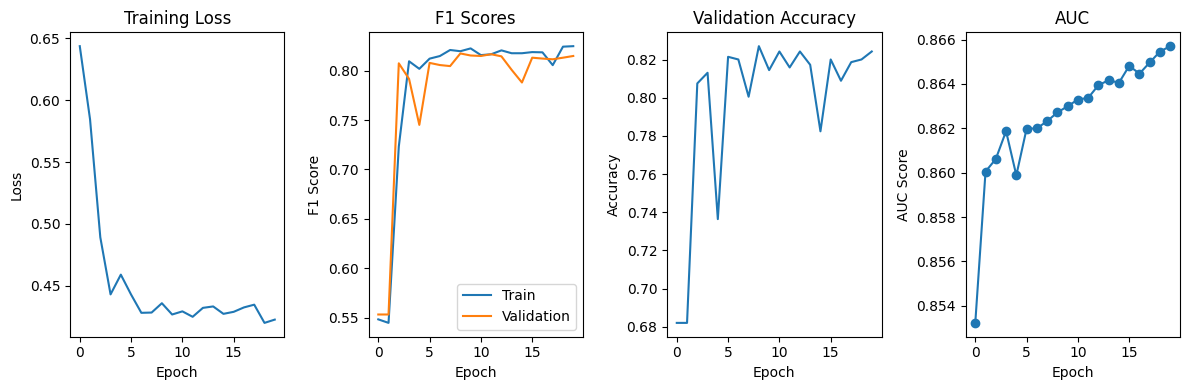

In [24]:
def plot_results(results):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 4, 1)
    plt.plot(results['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot F1 scores
    plt.subplot(1, 4, 2)
    plt.plot(results['train_f1'], label='Train')
    plt.plot(results['val_f1'], label='Validation')
    plt.title('F1 Scores')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 4, 3)
    plt.plot(results['val_acc'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    # Plot AUC
    plt.subplot(1, 4, 4)
    plt.plot(results['val_auc'], marker='o')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')

    plt.tight_layout()
    plt.show()

# Plot training results
plot_results(results)


Plotting the confusion matrix and ROC curve

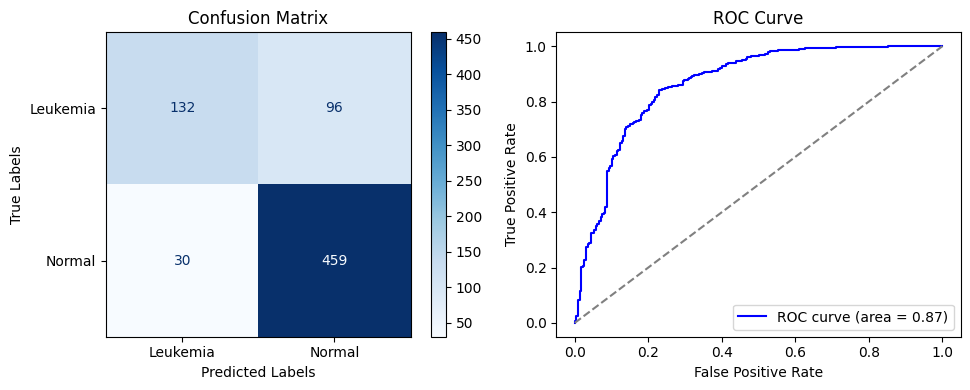

In [25]:
def plot_confusion_matrix_and_roc(y_true, y_pred, y_prob, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=axs[0])
    axs[0].set_title("Confusion Matrix")
    axs[0].set_xlabel("Predicted Labels")
    axs[0].set_ylabel("True Labels")

    # Plot ROC curve
    axs[1].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('ROC Curve')
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Evaluate on the test set and collect predictions
y_true, y_pred, y_prob = [], [], []
model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        y_true.extend(data.y.cpu().numpy())
        y_pred.extend(out.argmax(dim=1).cpu().numpy())
        y_prob.extend(out[:, 1].cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Plot confusion matrix and ROC curve with class labels
plot_confusion_matrix_and_roc(y_true, y_pred, y_prob, classes=["Leukemia", "Normal"])
